# Notebook to visualize **best hyperparameter** from ASHA HPO

## Plot trade-off curves against LoRA

In [1]:
monarch_ranks = [4, 8, 16, 32, 64]
monarch_rank_params = [0.14, 0.28, 0.56, 1.13, 2.25]
monarch_rank_res = [69.91, 69.8, 67.99, 69.51, 69.98]

lora_ranks = [4, 8, 16]
lora_params = [0.38, 0.76, 1.52]
lora_res = [65.0543, 68.3, 67.99667905057818]

monarch_blkszs = [1, 4, 16, 32, 64]
monarch_blksz_params = [0.14, 0.56, 2.25, 4.5, 9.]
monarch_blksz_res = [55.76, 62.39, 68.88, 67.9, 70.29]

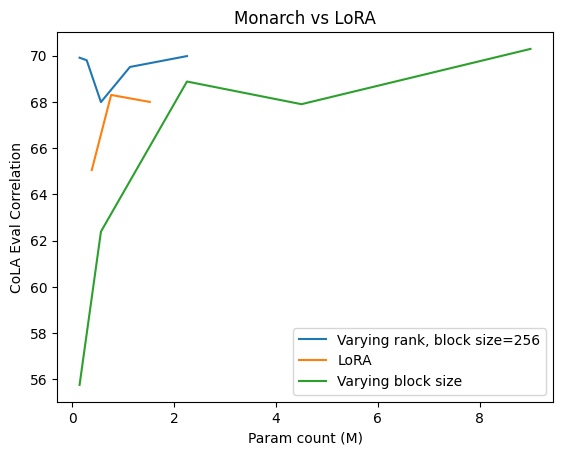

In [2]:
# plot rank vs lora, and then blksz vs lora as two lines connecting dots
import matplotlib.pyplot as plt

plt.title("Monarch vs LoRA")
plt.xlabel("Param count (M)")
plt.ylabel("CoLA Eval Correlation")

plt.plot(monarch_rank_params, monarch_rank_res, label="Varying rank, block size=256")
plt.plot(lora_params, lora_res, label="LoRA")
plt.plot(monarch_blksz_params, monarch_blksz_res, label="Varying block size")
# replace xticks with ranks
# monarch_ranks = [f"rank {r}" for r in monarch_ranks]
# plt.xticks(monarch_rank_params, monarch_ranks)


# lora_ranks = [f"rank {r}" for r in lora_ranks]
# plt.xticks(lora_params, lora_ranks)

plt.legend()
plt.savefig("monarch_vs_lora.png")
plt.show()


## Plot Hyperparams found in HPO

In [3]:
import glob
import json
tune_groups = ["dense rank 32", "dense rank 16"]
hp_groups = {}
results_path = "/results"
# find all folders with the tune_group name
for tune_group in tune_groups:
    jsons = glob.glob(f"{results_path}/**/{tune_group}/*.json", recursive=True)
    jsons = [json.load(open(j, "r")) for j in jsons]
    hp_groups[tune_group] = jsons

### plot by task or compare different groups

# Visualize monarch weight distribution

Text(0.5, 1.0, 'Llama instruction tuning block-diag layer 11 ')

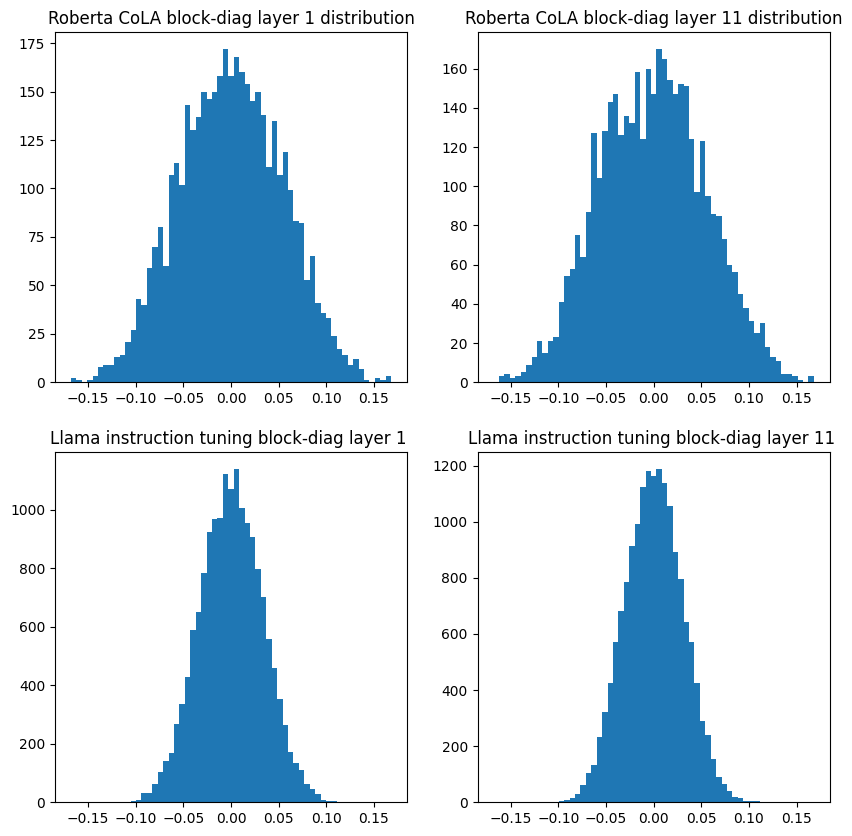

In [22]:
import torch
from safetensors import safe_open
import matplotlib.pyplot as plt
import numpy as np
from src.models.layers.blockdiag_butterfly_multiply import blockdiag_butterfly_multiply
# Set plot type
reconstruct = False
layer_type = "reconstructed" if reconstruct else "block-diag"
nbins = 60

plt.figure(figsize=(10, 10))
max_val = 0.01
with safe_open("results/monarch_roberta_glue/cola/default/checkpoint-7800/model.safetensors", framework="pt", device="cpu") as f:
    ax = plt.subplot(2, 2, 1)
    weights = blkdiag1 = f.get_tensor("roberta.encoder.layer.0.attention.self.query.blkdiag1").cuda()
    if reconstruct:
        blkdiag2 = f.get_tensor("roberta.encoder.layer.0.attention.self.query.blkdiag2").cuda()
        in_dim = blkdiag1.shape[0] * blkdiag1.shape[-1]
        weights = blockdiag_butterfly_multiply(torch.eye(in_dim).to(blkdiag1), blkdiag1, blkdiag2)
    max_val = weights.max().item()
    
    plt.hist(weights.cpu().flatten().numpy(), bins=np.linspace(-max_val, max_val, nbins))
    # plt.matshow(weights==0, fignum=0); ax.set_xlim(0, 256); ax.set_ylim(0, 256)
    plt.title(f"Roberta CoLA {layer_type} layer 1 distribution")
    
    ax = plt.subplot(2, 2, 2)
    weights = blkdiag1 = f.get_tensor("roberta.encoder.layer.11.attention.self.query.blkdiag1").cuda()
    if reconstruct:
        blkdiag2 = f.get_tensor("roberta.encoder.layer.11.attention.self.query.blkdiag2").cuda()
        in_dim = blkdiag1.shape[0] * blkdiag1.shape[-1]
        weights = blockdiag_butterfly_multiply(torch.eye(in_dim).to(blkdiag1), blkdiag1, blkdiag2).cpu().numpy()
    
    plt.hist(weights.cpu().flatten().numpy(), bins=np.linspace(-max_val, max_val, nbins))
    # plt.matshow(weights==0, fignum=0); ax.set_xlim(0, 256); ax.set_ylim(0, 256)
    plt.title(f"Roberta CoLA {layer_type} layer 11 distribution")

ax = plt.subplot(2, 2, 3)
llama_weights = torch.load("results/llama_mmlu/checkpoint-1683/pytorch_model-00001-of-00002.bin", map_location="cpu")
weights = blkdiag1 = llama_weights["model.layers.1.self_attn.q_proj.blkdiag1"].cuda()
if reconstruct:
    blkdiag2 = llama_weights["model.layers.1.self_attn.q_proj.blkdiag2"].cuda()
    in_dim = blkdiag1.shape[0] * blkdiag1.shape[-1]
    weights = blockdiag_butterfly_multiply(torch.eye(in_dim).to(blkdiag1), blkdiag1, blkdiag2).cpu().numpy()
plt.hist(weights.cpu().flatten().numpy(), bins=np.linspace(-max_val, max_val, nbins))
# plt.matshow(weights==0, fignum=0); ax.set_xlim(0, 256); ax.set_ylim(0, 256)
plt.title(f"Llama instruction tuning {layer_type} layer 1 ")

ax = plt.subplot(2, 2, 4)
weights = blkdiag1 = llama_weights["model.layers.11.self_attn.q_proj.blkdiag1"].cuda()
if reconstruct:
    blkdiag2 = llama_weights["model.layers.11.self_attn.q_proj.blkdiag2"].cuda()
    in_dim = blkdiag1.shape[0] * blkdiag1.shape[-1]
    weights = blockdiag_butterfly_multiply(torch.eye(in_dim).to(blkdiag1), blkdiag1, blkdiag2).cpu().numpy()
plt.hist(weights.cpu().flatten().numpy(), bins=np.linspace(-max_val, max_val, nbins))
# plt.matshow(weights==0, fignum=0); ax.set_xlim(0, 256); ax.set_ylim(0, 256)
plt.title(f"Llama instruction tuning {layer_type} layer 11 ")


Text(0.5, 1.0, 'Instruction tuning block-diag layer 11')

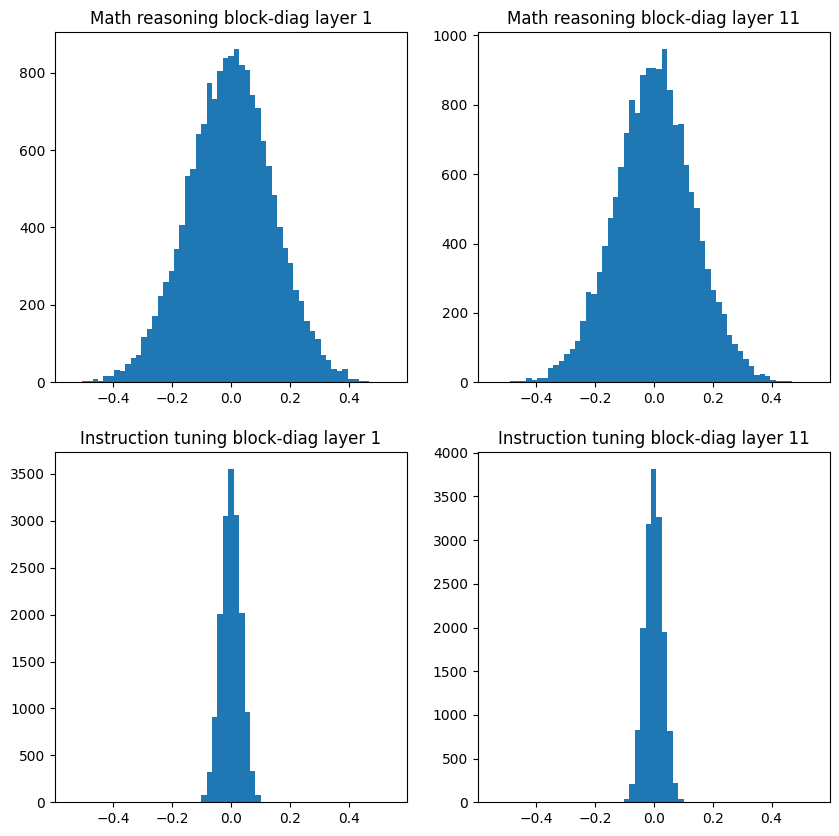

In [16]:
# Set plot type
reconstruct = False
layer_type = "reconstructed" if reconstruct else "block-diag"
nbins = 60

plt.figure(figsize=(10, 10))
math_ckpt = "pyreft/loreft/official_results/llama-7b-hf.math.20240501152313795515/checkpoint-3500/intervenable_model/pytorch_model.bin"
instruct_ckpt = "results/llama_mmlu/checkpoint-1683/pytorch_model-00001-of-00002.bin"
llama_math_weights = torch.load(math_ckpt, map_location="cpu")
llama_weights = torch.load(instruct_ckpt, map_location="cpu")
max_val = 0.1

plt.subplot(2, 2, 1)
weights = blkdiag1 = llama_math_weights["model.layers.1.self_attn.q_proj.blkdiag1"].cuda()
if reconstruct:
    blkdiag2 = llama_math_weights["model.layers.1.self_attn.q_proj.blkdiag2"].cuda()
    in_dim = blkdiag1.shape[0] * blkdiag1.shape[-1]
    weights = blockdiag_butterfly_multiply(torch.eye(in_dim).to(blkdiag1), blkdiag1, blkdiag2)

max_val = weights.max().item()

plt.hist(weights.detach().cpu().flatten().numpy(), bins=np.linspace(-max_val, max_val, nbins))
plt.title(f"Math reasoning {layer_type} layer 1")

plt.subplot(2, 2, 2)
weights = blkdiag1 = llama_math_weights["model.layers.11.self_attn.q_proj.blkdiag1"].cuda()
if reconstruct:
    blkdiag2 = llama_math_weights["model.layers.11.self_attn.q_proj.blkdiag2"].cuda()
    in_dim = blkdiag1.shape[0] * blkdiag1.shape[-1]
    weights = blockdiag_butterfly_multiply(torch.eye(in_dim).to(blkdiag1), blkdiag1, blkdiag2)


plt.hist(weights.detach().cpu().flatten().numpy(), bins=np.linspace(-max_val, max_val, nbins))
plt.title(f"Math reasoning {layer_type} layer 11")

plt.subplot(2, 2, 3)

weights = blkdiag1 = llama_weights["model.layers.1.self_attn.q_proj.blkdiag1"].cuda()
if reconstruct:
    blkdiag2 = llama_weights["model.layers.1.self_attn.q_proj.blkdiag2"].cuda()
    in_dim = blkdiag1.shape[0] * blkdiag1.shape[-1]
    weights = blockdiag_butterfly_multiply(torch.eye(in_dim).to(blkdiag1), blkdiag1, blkdiag2)

plt.hist(weights.detach().cpu().flatten().numpy(), bins=np.linspace(-max_val, max_val, nbins))
plt.title(f"Instruction tuning {layer_type} layer 1")

plt.subplot(2, 2, 4)
weights = blkdiag1 = llama_weights["model.layers.11.self_attn.q_proj.blkdiag1"].cuda()
if reconstruct:
    blkdiag2 = llama_weights["model.layers.11.self_attn.q_proj.blkdiag2"].cuda()
    in_dim = blkdiag1.shape[0] * blkdiag1.shape[-1]
    weights = blockdiag_butterfly_multiply(torch.eye(in_dim).to(blkdiag1), blkdiag1, blkdiag2)

plt.hist(weights.detach().cpu().flatten().numpy(), bins=np.linspace(-max_val, max_val, nbins))
plt.title(f"Instruction tuning {layer_type} layer 11")